<a href="https://colab.research.google.com/github/mananrajvir/music-recommender/blob/main/Hybrid_KMeans_and_KNN_Approach_for_Music_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hybrid KMeans + KNN Approach for Music Recommendation**


This project builds a hybrid machine learning pipeline for music recommendation using a combination of KMeans clustering (unsupervised) and K-Nearest Neighbors (supervised). By first grouping songs based on their audio feature similarities and then identifying the most similar tracks within those clusters, the system delivers more accurate and personalized recommendations. The approach leverages the strengths of both clustering and similarity search to enhance the listening experience.

The model groups similar songs based on characteristics like acousticness, energy and instrumentalness. The grouping can then be used to share similar/recommended songs based on shared audio traits, offering a personalized discovery experience.

This model can be especially useful for people who listen to music in different languages. The existing song reccomendation systems typically recommend songs of the same language, however, this model could be used to input to input the characteristics of a french or a hindi song, and find English songs that have similar song profile.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df_tracks = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Science/Other Projects/Music Recommender/SpotifyAudioFeaturesApril2019.csv')
df_tracks.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


The dataset used for this project includes song characteristics of 130,662 songs from spotify [https://www.kaggle.com/datasets/tomigelo/spotify-audio-features]. This dataset had to be used, instead of obtaining the audio features using the Spotify API because Spotify recently deprecated the get audio_features() function from their Web API.

In [3]:
#song that will be used for reccomendation later
test_track = df_tracks[df_tracks['track_id'] == '2rEUr28r7uvFUoEFpdYhGN']

#remove the test track from our training dataset
df_tracks = df_tracks[df_tracks['track_id'] != '2rEUr28r7uvFUoEFpdYhGN']

In [4]:
df_tracks.shape

(130662, 17)

In [5]:
#Create a list of all the numerical columns that will be used for our project
numerical_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'key', 'loudness', 'speechiness', 'tempo', 'valence']

## **Exploratory Data Analysis**

Before building the model, we conduct exploratory data analysis to gain a deeper understanding of the dataset and explore different visualization techniques.

> **I. Distribution of Acoustic Features**

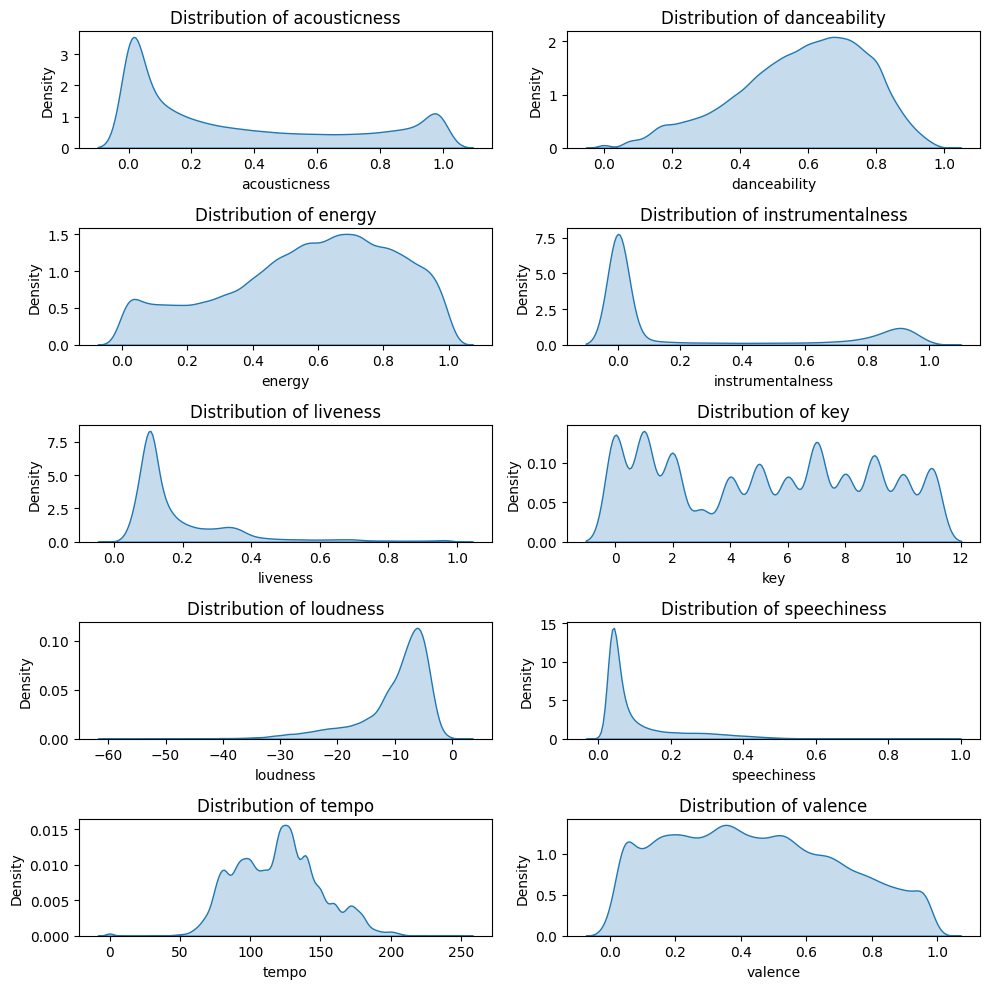

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(df_tracks[col], ax=axes[i], fill = True)
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

We start by visualizing the distribution of the audio features of songs in our dataset.

> **II. Correlation between the Audio Features**

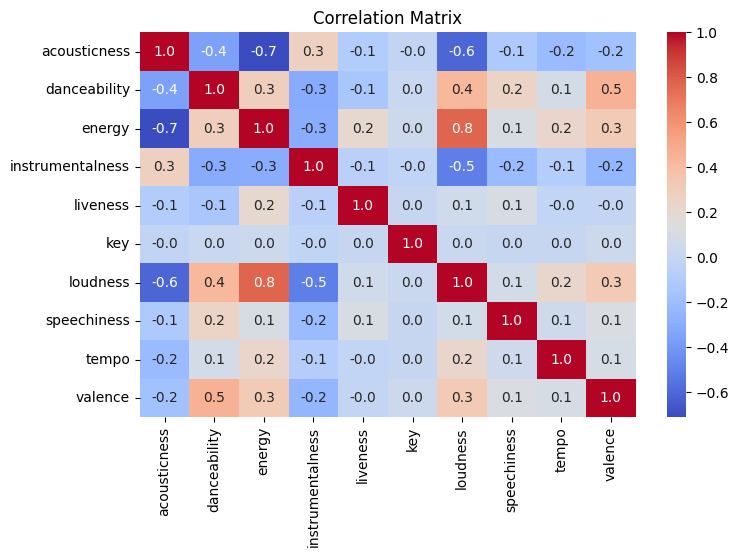

In [7]:
plt.figure(figsize=(8, 5))
sns.heatmap(df_tracks[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Matrix")
plt.show()

The plot reveals a strong positive correlation between a song's energy and loudness, which aligns with expectations — louder songs tend to feel more energetic. Additionally, we observe a strong negative correlation between energy and acousticness, indicating that more acoustic songs are generally less energetic.

However, none of these correlations are high enough to introduce collinearity concerns, so all features can be retained.

> **III. Correlation of Acoustic Features with Popularity**

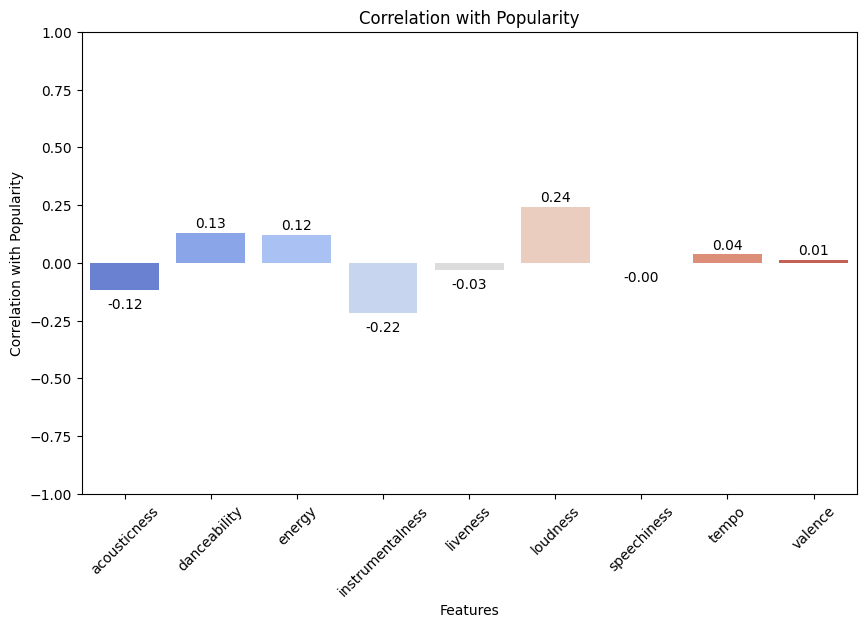

In [8]:
correlations = df_tracks[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity']].corr()['popularity'].drop('popularity')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=correlations.index, y=correlations.values, hue = correlations.index, palette='coolwarm')

for i, v in enumerate(correlations.values):
    ax.text(i, v + 0.02 if v > 0 else v - 0.08, f"{v:.2f}", ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Correlation with Popularity')
plt.title('Correlation with Popularity')
plt.ylim(-1,1)

plt.show()

The plot above illustrates the relationship between various song characteristics and popularity. The results indicate that higher popularity songs tend to be:
* Louder and more danceable
* Lower in acousticness and instrumentalness

These trends suggest that energetic, rhythm-driven tracks are generally more appealing to listeners.


> **IV. Visualizing Artist Sound Profiles**

In [9]:
#Create a dataset with the average value of audio features for an artist's songs
artist_features = df_tracks.groupby('artist_name').agg({
    'track_name': 'nunique',
    'acousticness': 'mean',
    'danceability': 'mean',
    'energy': 'mean',
    'instrumentalness': 'mean',
    'liveness': 'mean',
    'loudness': 'mean',
    'speechiness': 'mean',
    'tempo': 'mean',
    'valence': 'mean',
    'popularity': 'mean'
}).reset_index()

artist_features.sort_values(by = 'track_name', ascending = False, inplace=True)

#Visualize the audio features of the following artists' songs
artist_filter = ['Ludwig van Beethoven', 'Eagles', 'Elvis Presley', 'Snoop Dogg', 'David Guetta']
artist_features = artist_features[artist_features['artist_name'].isin(artist_filter)]
artist_features.drop(['track_name', 'popularity', 'loudness', 'tempo'], axis=1, inplace=True)

artist_features

<ipython-input-9-5c59e31a32db>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_features.drop(['track_name', 'popularity', 'loudness', 'tempo'], axis=1, inplace=True)


,artist_name,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
18660,Ludwig van Beethoven,0.960327,0.343621,0.115148,0.695998,0.154561,0.051974,0.252102
8933,Eagles,0.295694,0.541365,0.556850,0.068631,0.335950,0.037043,0.566586
9391,Elvis Presley,0.704357,0.509982,0.451019,0.139959,0.316540,0.060511,0.613930
27909,Snoop Dogg,0.194474,0.586235,0.692647,0.000076,0.224294,0.175486,0.512135
7481,David Guetta,0.057038,0.674521,0.789625,0.111610,0.155869,0.082429,0.415496


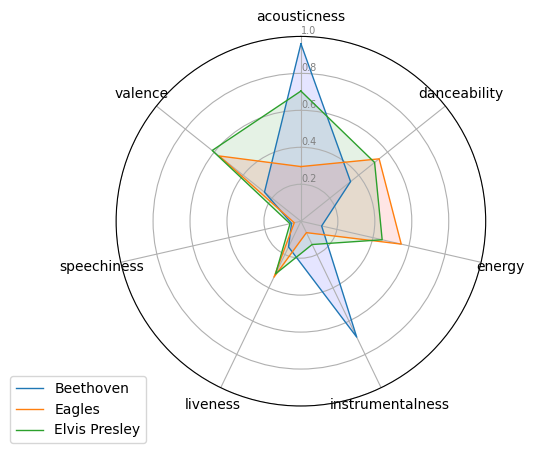

In [10]:
#Create a Radar Plot to visualize the Audio Features

import math

#the feature we will be plotting on the chart
categories=list(artist_features)[1:]
N = len(categories)

#the angle of each axis in the plot
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)

#set the first axis on top
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)

#draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2","0.4","0.6","0.8","1.0"], color="grey", size=7)
plt.ylim(0,1)

#Artist 1
values= artist_features[artist_features['artist_name'] == 'Ludwig van Beethoven'].reset_index(drop=True).drop(columns = ['artist_name']).values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Beethoven")
ax.fill(angles, values, 'b', alpha=0.1)

#Arist 2
values=artist_features[artist_features['artist_name'] == 'Eagles'].reset_index(drop=True).drop(columns = ['artist_name']).values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Eagles")
ax.fill(angles, values, 'r', alpha=0.1)

#Arist 3
values=artist_features[artist_features['artist_name'] == 'Elvis Presley'].reset_index(drop=True).drop(columns = ['artist_name']).values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Elvis Presley")
ax.fill(angles, values, 'g', alpha=0.1)

#Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

The radar plot provides a visual comparison of different artists' musical profiles. From the graph, we observe that:
* Beethoven's songs exhibit significantly higher acousticness and instrumentalness compared to those of Eagles and Elvis Presley.
* Elvis Presley's songs, on the other hand, showcase greater energy, danceability, and valence than Beethoven's compositions.

This visualization effectively highlights the distinct musical characteristics of each artist. Similar plots can also help visualize the music preferences for a user, based on their favorite tracks.

## **Recommendation Model**

The proposed model combines both unsupervised and supervised learning techniques to deliver personalized song recommendations:

1. First, it uses **KMeans clustering** (unsupervised learning) to **group songs based on their audio features** like energy, danceability, valence, tempo, and acousticness. These clusters typically represent different musical moods or genres.

2. When the user selects a new song, the model **assigns it to a cluster** using the trained KMeans model.

3. Then, within that cluster, it applies **K-Nearest Neighbors (KNN)** (supervised learning) to **identify the most similar songs** based on feature proximity.

This hybrid approach ensures the recommendations are not only **stylistically relevant** (thanks to clustering) but also **highly personalized** (thanks to similarity search via KNN), while remaining **scalable** for large song libraries.

### **I. Data Pre-processing**

In [11]:
df_tracks = df_tracks[['track_name', 'artist_name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'key', 'loudness', 'speechiness', 'tempo', 'valence']]

#drop any tracks with missing data
df_tracks = df_tracks.dropna()
df_tracks.head()

,track_name,artist_name,acousticness,danceability,energy,instrumentalness,liveness,key,loudness,speechiness,tempo,valence
0,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",YG,0.005820,0.743,0.339,0.000,0.0812,1,-7.678,0.4090,203.927,0.118
1,BAND DRUM (feat. A$AP Rocky),YG,0.024400,0.846,0.557,0.000,0.2860,8,-7.259,0.4570,159.009,0.371
2,Radio Silence,R3HAB,0.025000,0.603,0.723,0.000,0.0824,9,-5.890,0.0454,114.966,0.382
3,Lactose,Chris Cooq,0.029400,0.800,0.579,0.912,0.0994,5,-12.118,0.0701,123.003,0.641
4,Same - Original mix,Chris Cooq,0.000035,0.783,0.792,0.878,0.0332,7,-10.277,0.0661,120.047,0.928


Since we are using distance-based models like K-Neighbors, we first scale the features to a uniform range of (0,1). This prevents any single feature from disproportionately influencing the model due to differences in value ranges, ensuring fair and balanced distance calculations.

In [12]:
from sklearn.preprocessing import MinMaxScaler

#Create a dataframe with just the audio features that will be used for the model
features = df_tracks.drop(['track_name', 'artist_name'], axis=1)

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled[:2]

array([[0.00584337, 0.74598394, 0.339     , 0.        , 0.08128128,
        0.09090909, 0.84655211, 0.42339545, 0.81576347, 0.118     ],
       [0.02449799, 0.84939759, 0.557     , 0.        , 0.28628629,
        0.72727273, 0.85333139, 0.47308489, 0.63607925, 0.371     ]])

In [13]:
features_scaled = pd.DataFrame(features_scaled, columns = features.columns)

df_scaled = pd.concat([df_tracks[['track_name', 'artist_name']].reset_index(drop = True), features_scaled.reset_index(drop = True)], axis=1)
df_scaled.head()

,track_name,artist_name,acousticness,danceability,energy,instrumentalness,liveness,key,loudness,speechiness,tempo,valence
0,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",YG,0.005843,0.745984,0.339,0.000,0.081281,0.090909,0.846552,0.423395,0.815763,0.118
1,BAND DRUM (feat. A$AP Rocky),YG,0.024498,0.849398,0.557,0.000,0.286286,0.727273,0.853331,0.473085,0.636079,0.371
2,Radio Silence,R3HAB,0.025100,0.605422,0.723,0.000,0.082482,0.818182,0.875481,0.046998,0.459895,0.382
3,Lactose,Chris Cooq,0.029518,0.803213,0.579,0.912,0.099499,0.454545,0.774714,0.072567,0.492045,0.641
4,Same - Original mix,Chris Cooq,0.000035,0.786145,0.792,0.878,0.033233,0.636364,0.804501,0.068427,0.480221,0.928


### **II. Clustering using KMeans**

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Find the Optimal Number of Clusters (K)
def evaluate_kmeans(X, k_range):
  inertias = []
  silhouettes = []
  for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=10)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))
  return inertias, silhouettes

k_values = range(2, 11)
inertias, silhouettes = evaluate_kmeans(features_scaled, k_values)

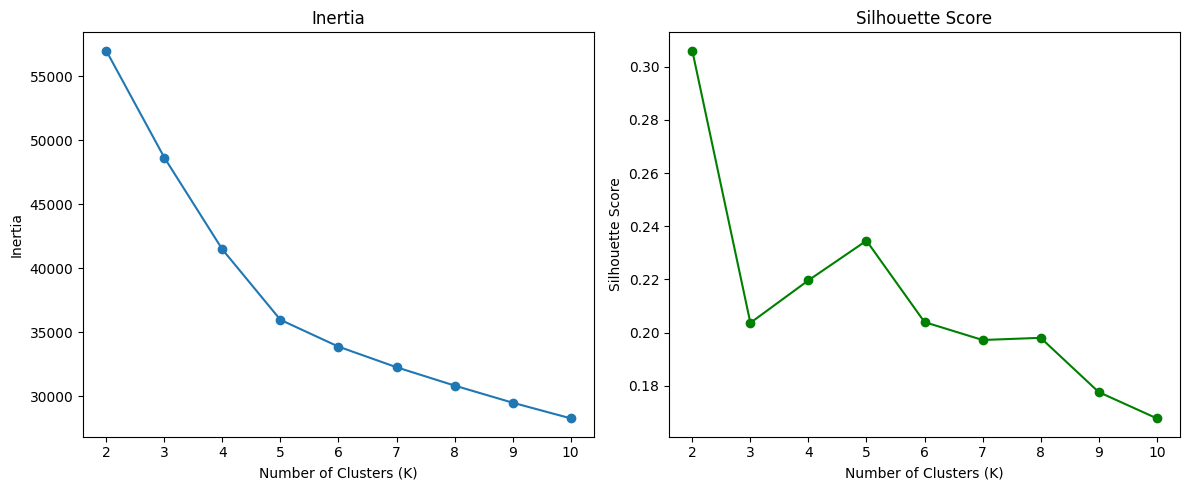

In [15]:
#Plot the Inertia and Silhouette Scores
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(k_values, inertias, marker = 'o')
plt.title("Inertia")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_values, silhouettes, marker = 'o', color = 'green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

We chose k = 5 as the optimal number of clusters because it aligns with the elbow point in the inertia plot, indicating a good balance between model complexity and performance. While the silhouette score peaked at k=2, k=5 still offered a strong score, suggesting well-separated clusters without oversimplifying the song groupings. Additionally, using K=2 (highest silhouette score) might give a very coarse classification (happy vs sad songs).

In [16]:
# Cluster the songs using kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state = 42, n_init = 10)
df_scaled['cluster'] = kmeans.fit_predict(features_scaled)

To better understand the clusters formed by the unsupervised learning model, we visualize the average values of key audio features for each cluster. This helps interpret the distinct musical characteristics that define each group (e.g., if one cluster is more 'energetic' and another is more 'chill)

In [17]:
#Visualize the clusters
cluster_means = df_scaled.groupby('cluster')[numerical_cols].mean().reset_index()
cluster_means

,cluster,acousticness,danceability,energy,instrumentalness,liveness,key,loudness,speechiness,tempo,valence
0,0,0.107460,0.591041,0.679369,0.805551,0.207396,0.483784,0.805920,0.079848,0.498416,0.401475
1,1,0.159112,0.638893,0.682312,0.021882,0.204968,0.164941,0.858775,0.138130,0.493202,0.474490
2,2,0.885644,0.379994,0.198140,0.850711,0.150031,0.440357,0.635287,0.059487,0.422580,0.257036
3,3,0.167594,0.647493,0.694124,0.019018,0.204712,0.756617,0.860425,0.140199,0.492440,0.530995
4,4,0.767661,0.517322,0.333727,0.036035,0.184753,0.478890,0.762769,0.102240,0.450477,0.372230


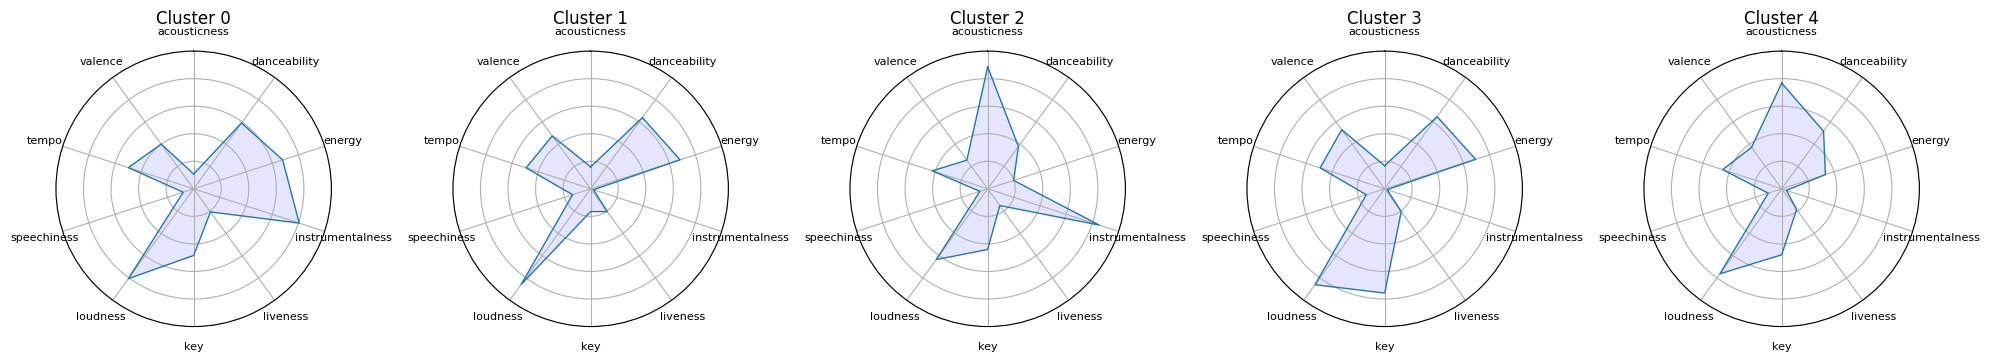

In [18]:
#Create a Radar Plot to visualize the Audio Features
import math

#the feature we will be plotting on the chart
categories = numerical_cols
N = len(numerical_cols)

#the angle of each axis in the plot
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

fig, axs = plt.subplots(1, 5, subplot_kw=dict(polar=True), figsize=(20, 4), dpi=100)

#Loop through all clusters
for i,cluster_id in enumerate(cluster_means['cluster']):
  values = cluster_means[cluster_means['cluster'] == cluster_id].reset_index(drop=True).drop(columns = ['cluster']).values.flatten().tolist()
  values += values[:1]

  #set the first axis on top
  ax = axs[i]
  ax.set_theta_offset(math.pi / 2)
  ax.set_theta_direction(-1)

  #draw ylabels
  ax.plot(angles, values, linewidth=1, linestyle='solid')
  ax.fill(angles, values, 'b', alpha=0.1)

  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(categories, fontsize = 8)
  ax.set_yticklabels([])
  ax.set_ylim(0,1)

  ax.set_title("Cluster " + str(cluster_id), size = 12, pad = 20)

plt.tight_layout()
plt.show()

From the radar plots above, we observe that:
* Songs in Cluster 0 are characterized by high instrumentalness and loudness, along with very low acousticness and liveness — suggesting they may belong to electronic or cinematic genres, such as EDM or instrumental soundtracks.
* Songs in Cluster 2 features tracks with very high acousticness and instrumentalness, but extremely low energy, speechiness, and liveness. This profile aligns more closely with ambient, acoustic, or classical music, which tend to be softer, less vocal, and more introspective in nature.

### **III. Predicting the Cluster for a New Song**

In [19]:
test_track

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
16523,Elvis Presley,2rEUr28r7uvFUoEFpdYhGN,Heartbreak Hotel,0.846,0.692,127533,0.213,0.000004,4,0.112,-11.942,1,0.0703,93.523,4,0.74,0


As a case study, we'll assume the user enjoys ```Heartbreak Hotel by Elvis Presley```, and uses it as the reference track to find similar songs through our hybrid recommendation system.

In [20]:
#Get the features of the test track
test_track_features = test_track[numerical_cols]

#Scale the test track features
test_track_features_scaled = scaler.transform(test_track_features)

#Assign the test track to a cluster
assigned_cluster = kmeans.predict(test_track_features_scaled)
print("The New Song Belongs to Cluster: " + str(assigned_cluster[0]))

The New Song Belongs to Cluster: 4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


The test track, Heartbreak Hotel, has been assigned to Cluster 4. To validate the consistency of the clustering approach, we can examine how many other Elvis Presley songs also fall into this cluster. If multiple tracks by the same artist are grouped together, it may indicate that the model is effectively capturing the artist's signature style and sound characteristics.

In [21]:
print("Elvis Songs in this cluster = " + str(df_scaled[(df_scaled['cluster'] == assigned_cluster[0]) & (df_scaled['artist_name'] == 'Elvis Presley')].shape[0]))

#Some other Elvis Presley songs in this cluster
df_scaled[(df_scaled['cluster'] == assigned_cluster[0]) & (df_scaled['artist_name'] == 'Elvis Presley')].head()

Elvis Songs in this cluster = 34


,track_name,artist_name,acousticness,danceability,energy,instrumentalness,liveness,key,loudness,speechiness,tempo,valence,cluster
8394,Suspicious Minds - Take 6,Elvis Presley,0.669679,0.677711,0.342,0.003690,0.157157,0.636364,0.777740,0.034990,0.453555,0.688,4
15623,That's All Right,Elvis Presley,0.830321,0.664659,0.402,0.000001,0.140140,0.181818,0.812219,0.036542,0.420993,0.714,4
18881,"Baby, Let's Play House",Elvis Presley,0.708835,0.671687,0.667,0.016000,0.125125,0.363636,0.825405,0.049689,0.417364,0.951,4
18958,It's Now or Never,Elvis Presley,0.526104,0.644578,0.445,0.000218,0.496496,0.363636,0.774213,0.037992,0.504810,0.765,4
19282,Are You Lonesome Tonight?,Elvis Presley,0.923695,0.428715,0.118,0.000201,0.102102,0.000000,0.705821,0.050828,0.305061,0.189,4


### **IV. Identifying Similar Tracks using K-Nearest Neighbors**

In the final step, we use the K-Nearest Neighbors (KNN) algorithm to recommend songs similar to the input track, but only within the same cluster.

After filtering songs that belong to the same cluster as the test track, we apply KNN to identify the top 5 most similar songs based on their audio features. This ensures that recommendations are both stylistically relevant and locally optimized within the user's preferred sound space.

In [22]:
from sklearn.neighbors import NearestNeighbors

#Get all the songs present in Cluster 4
cluster_songs = df_scaled[df_scaled['cluster'] == assigned_cluster[0]]
cluster_songs_features = cluster_songs[numerical_cols]

#Use KNN to find similar songs in the same cluster
knn = NearestNeighbors(n_neighbors = 5, metric = 'euclidean')
knn.fit(cluster_songs_features)
distances, indices = knn.kneighbors(test_track_features_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [23]:
recommendations = cluster_songs.iloc[indices[0]]
print("Recommended Songs:")
recommendations[['track_name', 'artist_name']]

Recommended Songs:


,track_name,artist_name
119965,There Is No Us - From “Star” Season 3,Star Cast
65383,Los Juicios de Dios,Duo Libano
49818,Wooden Heart,Elvis Presley
37002,Gimme Some Fox,Derek Stelk
65325,Quien Me Salvo,Duo Libano


After retrieving all songs assigned to the same cluster, we isolate their numerical audio features. Using the K-Nearest Neighbors (KNN) algorithm with Euclidean distance, we identified the above 5 closest tracks to the test song.

## **Conclusion**

In this project, we developed a hybrid song recommendation system by combining KMeans clustering and K-Nearest Neighbors (KNN).

First, songs were grouped based on audio features using KMeans, and then KNN was applied within each cluster to find similar tracks to a given test song.This approach ensures personalized and contextually relevant recommendations.

Potential applications include enhancing music streaming platforms, creating tailored playlists, and improving user engagement through more accurate song suggestions based on musical preferences.